## Basic Setup

The VAE model is based on https://keras.io/examples/generative/vae/


In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd

import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Flatten, Dense, Reshape, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# modify sys.path for it to contain the main repo path so we can import modules such as below
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

#from evaluation.plots import plot_history

tf.test.is_gpu_available()

True

In [2]:
# HYPERPARAMETERS
COMMENT = "Lets goo"

IMAGE_SIZE = (256, 256)
INPUT_SHAPE = IMAGE_SIZE + (3,)

THRESHOLD_PERCENTAGE = 95

BOTTLENECK_DIM = 512
BATCH_SIZE = 32
EPOCHS = 1
LOSS = 'mae'
OPTIMIZER = 'adam'
DROPOUT = 0.3

In [5]:
from typing import Tuple
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

def get_data(category: str, 
             batch_size: int, 
             image_size: Tuple[int, int] = (256, 256), 
             color_mode: str = 'rgb', 
             validation_split: float = 0.2) -> Tuple[Sequence, Sequence, Sequence]:
    """
    Generates data generators for training, validation, and testing datasets.

    Args:
        category (str): The category of the dataset to be used.
        batch_size (int): The size of the batches of data.
        image_size (Tuple[int, int], optional): Target size of the images (width, height). Defaults to (256, 256).
        color_mode (str, optional): Color mode, either 'rgb' or 'grayscale'. Defaults to 'rgb'.
        validation_split (float, optional): Fraction of training data to use for validation. Defaults to 0.2.

    Returns:
        Tuple[Sequence, Sequence, Sequence]: 
        A tuple containing the training, validation, and test data generators.
    """
    data_dir = f'//kaggle/input/mv-tech-screw/data (kopia)/{category}'
    train_dir = f'{data_dir}/train'
    test_dir = f'{data_dir}/test'

    datagen_train = ImageDataGenerator(
        rescale=1./255, 
        validation_split=validation_split
    )

    datagen_test = ImageDataGenerator(
        rescale=1./255
    )

    train_generator = datagen_train.flow_from_directory(
        train_dir,
        target_size=image_size,  # Use the modular image size
        batch_size=batch_size,
        class_mode='input',
        color_mode=color_mode,  # Use the modular color mode
        subset='training',
        shuffle=True  # Shuffle training data
    )

    validation_generator = datagen_train.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='input',
        color_mode=color_mode,
        subset='validation',
        shuffle=False
    )

    test_generator = datagen_test.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='input',  # Changed to 'input' for consistency with autoencoder
        color_mode=color_mode,
        shuffle=False
    )
    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = get_data(
    category='screw', 
    batch_size=32, 
    image_size=(256, 256), 
    color_mode='rgb'
)

Found 256 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 160 images belonging to 6 classes.


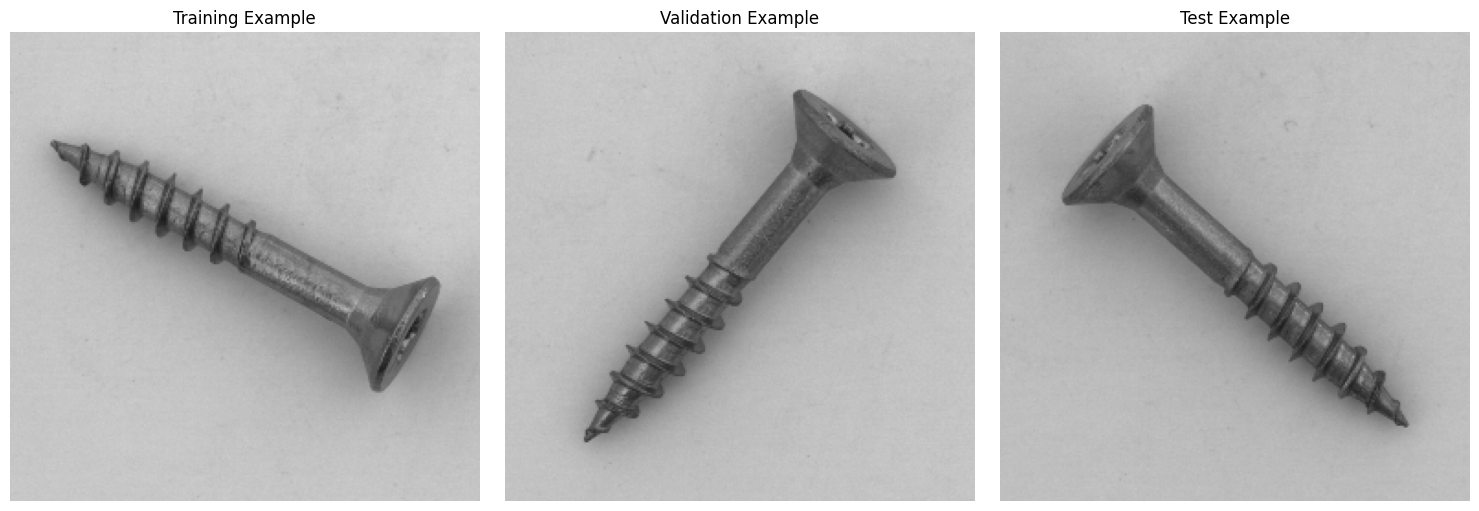

In [6]:
import matplotlib.pyplot as plt

# Function to plot examples from training, validation, and test datasets
def plot_examples(train_gen, val_gen, test_gen):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Extract one example from each generator
    train_sample = next(train_gen)[0][0]  # First batch, first image
    val_sample = next(val_gen)[0][0]
    test_sample = next(test_gen)[0][0]

    # Plot the training example
    axes[0].imshow(train_sample)
    axes[0].set_title("Training Example")
    axes[0].axis("off")

    # Plot the validation example
    axes[1].imshow(val_sample)
    axes[1].set_title("Validation Example")
    axes[1].axis("off")

    # Plot the test example
    axes[2].imshow(test_sample)
    axes[2].set_title("Test Example")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function with the generated data
plot_examples(train_generator, validation_generator, test_generator)


In [7]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

In [9]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 100

# Encoder
encoder_inputs = keras.Input(shape=(256, 256, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)  # (128, 128, 32)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)               # (64, 64, 64)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)              # (32, 32, 128)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)              # (16, 16, 256)
x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)              # (8, 8, 512)
x = layers.Conv2D(1024, 3, activation="relu", strides=2, padding="same")(x)             # (4, 4, 1024)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)


z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
print(encoder.summary())


# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 1024, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 1024))(x)  # (4, 4, 1024)
x = layers.Conv2DTranspose(512, 3, activation="relu", strides=2, padding="same")(x)  # (8, 8, 512)
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)  # (16, 16, 256)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)  # (32, 32, 128)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)   # (64, 64, 64)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)   # (128, 128, 32)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", strides=2, padding="same")(x)  # (256, 256, 3)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
print(decoder.summary())


# VAE Model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        if isinstance(data, tuple):
            print(data[0])
            print(data[1])
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        # Compute gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}


vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.MeanSquaredError())


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │     18,496 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     73,856 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │    295,168 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 512) │  1,180,160 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 4, 4,      │  4,719,616 │ conv2d_10[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 16384)     │          0 │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │  1,048,640 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 100)       │      6,500 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 100)       │      6,500 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 100)       │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,349,832 (28.04 MB)

 Trainable params: 7,349,832 (28.04 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16384)          │     1,654,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 8, 8, 512)      │     4,719,104 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 16, 16, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 32, 32, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 256, 256, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,941,955 (30.30 MB)

 Trainable params: 7,941,955 (30.30 MB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 600ms/step - kl_loss: 74.0907 - loss: 37082.0273 - reconstruction_loss: 37007.9375 - val_loss: 0.0069
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 437ms/step - kl_loss: 74.7971 - loss: 37002.3047 - reconstruction_loss: 36927.5078 - val_loss: 0.0065
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 412ms/step - kl_loss: 76.4944 - loss: 37015.1914 - reconstruction_loss: 36938.6953 - val_loss: 0.0063
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step - kl_loss: 78.3941 - loss: 37023.5391 - reconstruction_loss: 36945.1445 - val_loss: 0.0062
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 425ms/step - kl_loss: 76.4641 - loss: 36951.8086 - reconstruction_loss: 36875.3438 - val_loss: 0.0061
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step - kl_loss: 82.0498 - loss: 36951.5000 - reconstruction_loss: 36869.4492 - val_loss: 0.0060
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 424ms/step - kl_loss: 79.2799 - loss: 36863.7539 - reconstruction_loss: 36784.4766 - val_loss: 0.0059
Epoch

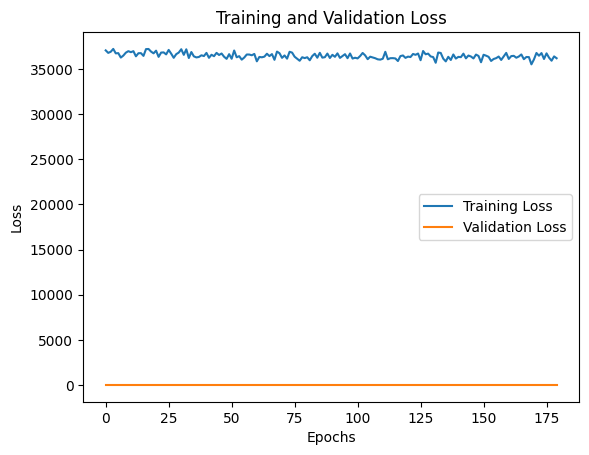

In [13]:
EPOCHS = 500  # Adjust as needed
BATCH_SIZE = 16  # Match the batch size of your generator

# Define callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint(filepath='vae_best_model.keras', save_best_only=True)

# Train the Variational Autoencoder
history = vae.fit(
    train_generator,
    None,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint],
)

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

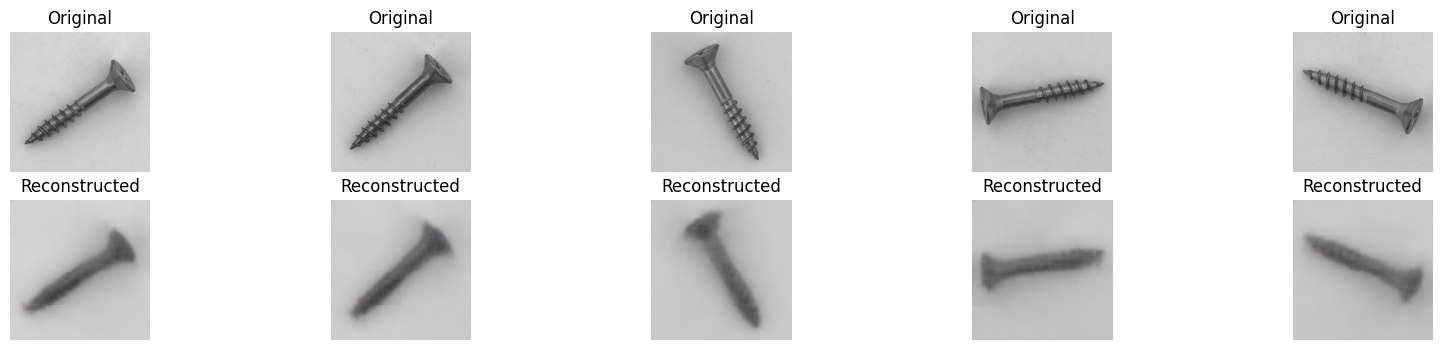

In [14]:
import matplotlib.pyplot as plt

# Fetch one batch
batch_x, _ = next(train_generator)

# Generate reconstructions
z_mean, z_log_var, z = vae.encoder(batch_x)
reconstructed_images = vae.decoder(z)

# Display original and reconstructed images
n = 5  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(batch_x[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].numpy())
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()